# A Post Office – A Real Life Story

*Paul Bayer, 2020-09-14, v0.4*

Let us begin with an everyday story: there is a small post office with one clerk serving the arriving customers. Customers have differing wishes leading to different serving times, from `1 - 5 minutes`. We have to add a little variation to serving times counting for variation in customer habits and clerk performance. The arrival rate of customers is about 18 per hour, every `3.33 minutes` or `3 minutes, 20 seconds` on average. Our post office is small and customer patience is limited, so queue length is limited to 5 customers. 

We have provided 10% extra capacity, so our expectation is that there should not be too many customers discouraged for long waiting times or for full queues.

![post office](../../docs/src/img/PostOffice.png)

Let's do a process-based simulation using [`DiscreteEvents`](https://github.com/pbayer/DiscreteEvents.jl). We need 

1. a source: all the **people**, providing an unlimited supply for customers,
2. **customers** with their demands and their limited patience,
3. a **queue** and
4. our good old **clerk**.

First we must load the needed modules, describe a customer and define some needed helper functions. 

In [1]:
using DiscreteEvents, Random, Distributions, DataFrames

mutable struct Customer
    id::Int64
    arrival::Float64
    request::Int64

    Customer(n::Int64, arrival::Float64) = new(n, arrival, rand(DiscreteUniform(1, 5)))
end

full(q::Channel) = length(q.data) >= q.sz_max
logevent(nr, queue::Channel, info::AbstractString, wt::Number) =
    push!(df, (round(tau(), digits=2), nr, length(queue.data), info, wt))

logevent (generic function with 1 method)

Then we define functions for our processes: people and clerk.

In [2]:
function people(clk::Clock, output::Channel, β::Float64)
    i = 1
    while true
        Δt = rand(Exponential(β))
        delay!(clk, Δt)
        if !full(output)
            put!(output, Customer(i, tau(clk)))
            logevent(i, output, "enqueues", 0)
         else
            logevent(i, output, "leaves - queue is full!", -1)
        end
        i += 1
    end
end

function clerk(clk::Clock, input::Channel)
    cust = take!(input)
    Δt = cust.request + randn()*0.2
    logevent(cust.id, input, "now being served", tau(clk) - cust.arrival)
    delay!(clk, Δt)
    logevent(cust.id, input, "leaves", tau(clk) - cust.arrival)
end

clerk (generic function with 1 method)

Then we have to create out data, register and startup the processes:

In [3]:
resetClock!(𝐶)  # for repeated runs it is easier if we reset our central clock here
Random.seed!(2019)  # seed random number generator for reproducibility
queue = Channel(5)  # thus we determine the max size of the queue

df = DataFrame(time=Float64[], cust=Int[], qlen=Int64[], status=String[], wtime=Float64[])

process!(Prc(1, people, queue, 3.333)) # register the functions as processes
process!(Prc(2, clerk, queue))

2

Then we can simply run the simulation. We assume our time unit being minutes, so we run for 600 units:

In [4]:
println(run!(𝐶, 600))
println("$(length(queue.data)) customers yet in queue")

run! finished with 348 clock events, 0 sample steps, simulation time: 600.0
0 customers yet in queue


Our table has registered it all:

In [5]:
df

,time,cust,qlen,status,wtime
,Float64,Int64,Int64,String,Float64
1,1.2,1,1,enqueues,0.0
2,1.2,1,0,now being served,0.0
3,2.42,1,0,leaves,1.22333
4,14.46,2,1,enqueues,0.0
5,14.46,2,0,now being served,0.0
6,15.33,2,0,leaves,0.869507
7,15.59,3,1,enqueues,0.0
8,15.59,3,0,now being served,0.0
9,16.03,4,1,enqueues,0.0


In [6]:
last(df, 5)

,time,cust,qlen,status,wtime
,Float64,Int64,Int64,String,Float64
1,592.49,177,0,now being served,2.89088
2,594.74,178,1,enqueues,0.0
3,595.95,177,1,leaves,6.35064
4,595.95,178,0,now being served,1.21605
5,598.03,178,0,leaves,3.29656


In [7]:
describe(df[df[!, :wtime] .> 0, :wtime])

Summary Stats:
Length:         314
Missing Count:  0
Mean:           7.326661
Minimum:        0.070575
1st Quartile:   3.690368
Median:         6.139574
3rd Quartile:   9.958741
Maximum:        23.627103
Type:           Float64


In $600$ minutes simulation time, we registered $178$ customers and $518$ status changes. The mean and median waiting times were around $7$ minutes.

In [8]:
by(df, :status, df -> size(df, 1))

,status,x1
,String,Int64
1,enqueues,170
2,now being served,170
3,leaves,170
4,leaves - queue is full!,8


Of the $178$ customers, $170$ of them participated in the whole process and were served, but $8$ left beforehand because the queue was full: 

In [9]:
df[df.wtime .< 0,:]

,time,cust,qlen,status,wtime
,Float64,Int64,Int64,String,Float64
1,134.96,36,5,leaves - queue is full!,-1.0
2,140.39,38,5,leaves - queue is full!,-1.0
3,166.69,47,5,leaves - queue is full!,-1.0
4,169.14,49,5,leaves - queue is full!,-1.0
5,169.2,50,5,leaves - queue is full!,-1.0
6,212.92,64,5,leaves - queue is full!,-1.0
7,237.76,72,5,leaves - queue is full!,-1.0
8,575.38,172,5,leaves - queue is full!,-1.0


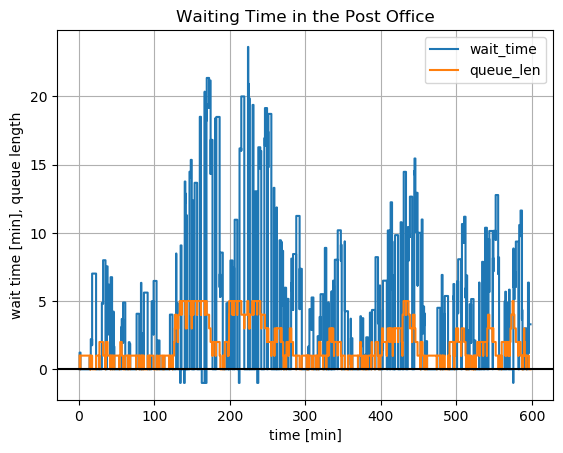

In [10]:
using PyPlot
step(df.time, df.wtime)
step(df.time, df.qlen)
axhline(y=0, color="k")
grid()
xlabel("time [min]")
ylabel("wait time [min], queue length")
title("Waiting Time in the Post Office")
legend(["wait_time", "queue_len"]);

Many customers had waiting times of more than 10, 15 up to even more than 20 minutes. The negative waiting times were the 5 customers, which left because the queue was full.

So many customers will remain angry. If this is the situation all days, our post office will have an evil reputation. What should we do?

## Conclusion

Even if our process runs within predetermined bounds (queue length, customer wishes …), it seems to fluctuate wildly and to produce unpredicted effects. We see here the **effects of variation** in arrivals, in demands and in serving time on system performance. In this case 10% extra capacity is not enough to provide enough buffer for variation and for customer service – even if our post clerk is the most willing person.

Even for such a simple everyday system, we cannot say beforehand – without reality check – which throughput, waiting times, mean queue length, capacity utilization or customer satisfaction will emerge. Even more so for more complicated systems in production, service, projects and supply chains with multiple dependencies.

If we had known the situation beforehand, we could have provided standby for our clerk or install an automatic stamp dispenser for cutting the short tasks … 

We should have done a simulation. We should have known `DiscreteEvents` before …  😄